In [39]:
from msmbuilder.dataset import dataset
xyz = dataset('/media/scottzhuang/data/MD/md_prep/msm/4NPQ_BA1_pH70_md5/msm/' + "msm?.protein.xtc",
              topology='/media/scottzhuang/data/MD/md_prep/msm/4NPQ_BA1_pH70_md5/msm/' + "msm.gro",
              stride=1)
print("{} trajectories".format(len(xyz)))
# msmbuilder does not keep track of units! You must keep track of your
# data's timestep
to_ns = 2
print("with length {} ns".format(set(len(x)*to_ns for x in xyz)))

5 trajectories
with length {402} ns


In [40]:
from msmbuilder.featurizer import DihedralFeaturizer
featurizer = DihedralFeaturizer(types=['phi', 'psi'])
diheds = xyz.fit_transform_with(featurizer, '/media/scottzhuang/data/MD/md_prep/msm/4NPQ_BA1_pH70_md5/msm/2diheds/', fmt='dir-npy')

print(xyz[0].xyz.shape)
print(diheds[0].shape)

(201, 27770, 3)
(201, 6216)


In [41]:
from msmbuilder.preprocessing import RobustScaler
scaler = RobustScaler()
scaled_diheds = diheds.fit_transform_with(scaler, '/media/scottzhuang/data/MD/md_prep/msm/4NPQ_BA1_pH70_md5/msm/scaled_diheds/', fmt='dir-npy')

print(diheds[0].shape)
print(scaled_diheds[0].shape)

(201, 6216)
(201, 6216)


In [42]:
from msmbuilder.decomposition import tICA
tica_model = tICA(lag_time=2, n_components=4)
# fit and transform can be done in seperate steps:
tica_model = scaled_diheds.fit_with(tica_model)
tica_trajs = scaled_diheds.transform_with(tica_model, '/media/scottzhuang/data/MD/md_prep/msm/4NPQ_BA1_pH70_md5/msm/ticas/', fmt='dir-npy')

print(diheds[0].shape)
print(tica_trajs[0].shape)

/home/scottzhuang/anaconda3/envs/deepchem/lib/python3.5/site-packages/msmbuilder/decomposition/tica.py:405: UserWarning: The number of features (6216) is greater than the length of the data (201). The covariance matrix is not guaranteed to be positive definite.
  warnings.warn("The number of features (%d) is greater than the length of the data (%d). The covariance matrix is not guaranteed to be positive definite." % (X.shape[1], X.shape[0]))


(201, 6216)
(201, 4)


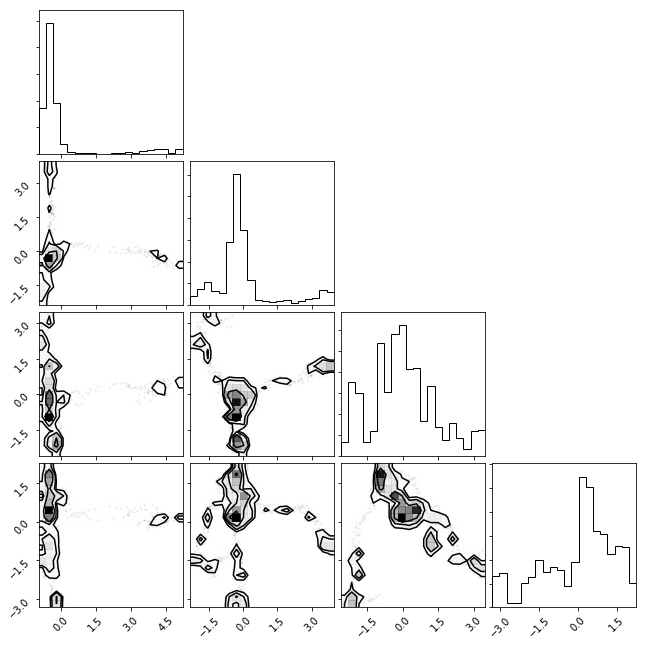

In [43]:
%matplotlib inline
import msmexplorer as msme
import numpy as np
txx = np.concatenate(tica_trajs)
_ = msme.plot_histogram(txx)

In [45]:
from msmbuilder.cluster import MiniBatchKMeans
clusterer = MiniBatchKMeans(n_clusters=100, random_state=42)
clustered_trajs = tica_trajs.fit_transform_with(
    clusterer, '/media/scottzhuang/data/MD/md_prep/msm/4NPQ_BA1_pH70_md5/msm/msm_kmeans/', fmt='dir-npy'
)

print(tica_trajs[0].shape)
print(clustered_trajs[0].shape)

(201, 4)
(201,)


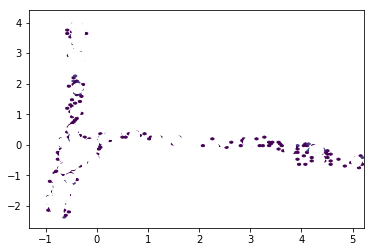

In [46]:
from matplotlib import pyplot as plt
plt.hexbin(txx[:,0], txx[:,1], bins='log', mincnt=1, cmap='viridis')
plt.scatter(clusterer.cluster_centers_[:,0],
            clusterer.cluster_centers_[:,1], 
            s=100, c='w')

In [54]:
from msmbuilder.msm import MarkovStateModel
from msmbuilder.utils import dump
msm = MarkovStateModel(lag_time=2, n_timescales=10)
msm.fit(clustered_trajs)

MSM contains 77 strongly connected components above weight=0.50. Component 28 selected, with population 8.442211%


MarkovStateModel(ergodic_cutoff='on', lag_time=2, n_timescales=10,
         prior_counts=0, reversible_type='mle', sliding_window=True,
         verbose=True)

In [57]:
assignments

[array([ 6,  7,  6,  7,  6,  7,  6,  7,  6,  7, 15,  7, 15,  7,  5,  5,  5,
         5,  5,  5,  5,  5,  5,  5,  5,  3, 13,  3,  3,  3,  3,  3,  3, 12,
         3, 12, 12, 12, 12, 12, 12, 12, 12]),
 array([ 6,  0,  8,  0,  8,  0,  0,  0,  0,  0,  0,  0,  0,  8,  8,  8,  0,
         8,  0,  8,  0,  8,  0,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         0,  8,  0,  0,  0,  0,  0, 11, 11, 11,  2, 11,  2, 11,  2, 11,  2,
        11,  2, 11,  2, 11,  2, 11,  2,  2,  2,  2,  9, 14,  9, 14,  9, 14,
         9, 14,  9, 14,  4,  9,  4,  9,  4,  9,  4,  9,  4,  4,  4,  4,  4]),
 array([ 6,  6,  6,  6,  6,  6,  6,  8, 15,  8, 15,  8, 15, 15, 10, 15, 10,
        10, 10, 10, 10, 10, 10,  9, 10, 13,  9, 13, 13, 13, 13, 13, 13, 13,
        13, 13, 13, 13, 13, 13, 13]),
 array([ 6,  6,  6,  6, 15,  6, 15,  6,  8,  6,  8, 15,  8,  1,  1,  0,  1,
         0,  1,  0,  9,  0]),
 array([ 6, 15,  6, 15,  8,  1,  6,  1])]

In [48]:
assignments = clusterer.partial_transform(txx)
assignments = msm.partial_transform(assignments)
msme.plot_free_energy(txx, obs=(0, 1), n_samples=10000,
                      pi=msm.populations_[assignments],
                      xlabel='tIC 1', ylabel='tIC 2')
plt.scatter(clusterer.cluster_centers_[msm.state_labels_, 0],
            clusterer.cluster_centers_[msm.state_labels_, 1],
            s=1e4 * msm.populations_,       # size by population
            c=msm.left_eigenvectors_[:, 1], # color by eigenvector
            cmap="coolwarm",
            zorder=3) 
plt.colorbar(label='First dynamical eigenvector')
plt.tight_layout()

IndexError: too many indices for array

In [61]:
msm.timescales_

array([ 11.63073688,  10.51359385,   5.02482097,   4.71710952])

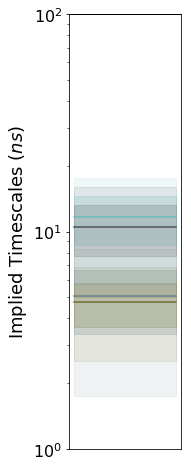

In [60]:
msme.plot_timescales(msm, n_timescales=5,
                     ylabel='Implied Timescales ($ns$)')

In [62]:
from msmbuilder.lumping import PCCAPlus
pcca = PCCAPlus.from_msm(msm, n_macrostates=4)
macro_trajs = pcca.transform(clustered_trajs)

Optimization terminated successfully.
         Current function value: -3.310207
         Iterations: 9
         Function evaluations: 98


In [63]:
msme.plot_free_energy(txx, obs=(0, 1), n_samples=10000,
                      pi=msm.populations_[assignments],
                      xlabel='tIC 1', ylabel='tIC 2')
plt.scatter(clusterer.cluster_centers_[msm.state_labels_, 0],
            clusterer.cluster_centers_[msm.state_labels_, 1],
            s=50,
            c=pcca.microstate_mapping_,
            zorder=3
           )
plt.tight_layout()

IndexError: too many indices for array